## Solução para o jogo

Modelo de Dou et al., 2020.



In [1]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
#libraries
import numpy as np
from numba import jit, jitclass, njit, float64,  int32, char #para otimizar as funções
import numba as nb
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from scipy.stats import beta

from random import uniform #para a draw da uniforme(0,1)
import math

import time #tempo de computação


In [3]:
#abre o site
import webbrowser

# webbrowser.open('https://www.labri.fr/perso/nrougier/from-python-to-numpy/')

### Passo 0: definindo comandos do latex para facilitar a escrita

Aqui também podemos descrever as funções do jogo

$%conjunto de informações de s em t$
$\newcommand{\Is}[1]{\theta_{s{#1}}, l_{s{#1}}, l_{j{#1}}}$
$%macros para facilitar a escrita de funções valor$


$%conjunto de informações de j em t$
$\newcommand{\Ij}[1]{\theta_{j{#1}}, l_{s{#1}}, l_{j{#1}}}$

$%função valor de s em t$
$\newcommand{\Ws}[1]{ W_{s{#1}} ( \Is{{#1}}) }$

$%função valor de j em t$
$\newcommand{\Wj}[1]{ W_{j{#1}} ( \Ij{{#1}}) }$

$%operador esperança de s em t. 2 argumentos: o primeiro é o período e o segundo é o termo que ela tira a esperança$

$\newcommand{\Es}[2]{\mathbb{E_{#1}^{s} \big[ {#2}  \mid ( \Is{#1} )    \big] }}$

$%minúsculo não mostra o conjunto de informação$
$\newcommand{\es}[2]{\mathbb{E_{#1}^{s} \big[ {#2}  \big] }}$

$%minúsculo não mostra o conjunto de informação$
$%final b de big para aumentar os parênteses$
$\newcommand{\esb}[2]{\mathbb{E_{#1}^{s} \bigg[ {#2}  \bigg] }}$

$%operador esperança de j em t. 2 argumentos: o primeiro é o período e o segundo é o termo que ela tira a esperança$

$\newcommand{\Ej}[2]{\mathbb{E_{#1}^{j} \big[ {#2}  \mid ( \Ij{#1} )    \big] }}$

$%minúsculo não mostra o conjunto de informação$
$\newcommand{\ej}[2]{\mathbb{E_{#1}^{j} \big[ {#2}  \big] }}$

$%minúsculo não mostra o conjunto de informação$
$%final b para aumentar os parênteses$
$\newcommand{\ejb}[2]{\mathbb{E_{#1}^{j} \bigg[ {#2}  \bigg] }}$


$%comando para usar o máximo com chaves grandes$
$\newcommand{\maximo}[1]{\max \bigg\{ #1 \bigg\}}$


In [130]:
#parâmetros do jogo, apenas para ilustração a princípio
#coloquei os mesmos parãmetros dos autores (Tabela 4). No caso dos dados, usei as médias (Panel B)





μ = 4.566 #número de meses entre períodos, não entendi onde entra ainda
ρ = 0.884 # (1 - ρ) é a taxa de depreciação da empresa a cada período
β = 9.84 #usamos aqui a distribuição Uniforme, depois vamos mudar isto
c0 = 0.044 #custo fixo de ir para a corte
c1 = 0.015 #custo variável de ir para a corte


θ_s0 = 0.28 #habilidade inicial de s
θ_j0 = 0.36 #habilidade inicial de j

λj = 0.346 #probabilidade de j propor a cada turno. Não precisaremos estimar, isso virá dos dados

In [131]:
#informações que virão dos dados

#valores médios de L, Dj e Ds. Arredondei para duas casas decimais ao simular o modelo
# 0.2493718592964824
# 0.35113065326633164
# 0.27701005025125625





Vmax = 1
L = 0.25

#valores da dívida de cada jogador (virá dos dados, aqui é exemplo):
Ds = 0.28
Dj = 0.35


### Passo 1: número máximo de turnos

Calculado com base nos parâmetros


t é tal que

$$ \rho^{t-1} V_{max} = L$$


$$ t = \frac{log(L) - log(V_{max})} {log(\rho)} +1 $$

In [132]:
#função para calcular o máximo de turnos do jogo
def maximo_de_turnos(ρ, Vmax, L):
    
    T = (math.log(L) - math.log(Vmax))/math.log(ρ) + 1
    
    #arredonda para baixo porque queremos o último período no qual o valor de continuação é maior ou igual ao de liquidação
    T = math.floor(T)
        
    return T

T = maximo_de_turnos(ρ, Vmax, L)

In [133]:
#valor máximo de reorganização da firma a cada período


#sequência de valores da firma para cada período
#tem que deixar como dtype = np.float para pegar valores decimais

def Vt(Vmax, T, ρ):
    
    

    V = np.empty(T, dtype=np.float64)

    for t in range(T):
        
        #no período t = 0, ela é o Vmax. E no período t = 1, também, pois não depreciou ainda

        if(t == 0):
            V[t] = Vmax

        else:
            V[t] = ρ**(t-1) * Vmax
            
    return V

V = Vt(Vmax, T, ρ)

In [134]:
#slots para cada habilidade
grid_size = 100

θlow = 0.01 
θhigh = 1

#tem um problema na aproximação de 0.07, então fiz manual. Não consegui achar outra alternativa por enquanto
#tentei 1) fazer uma sequencia de inteiros e dividir por 100; 2) usar float32; 3) usar double... todas elas zoaram cálculos
θvals = np.array(np.linspace(θlow, θhigh, grid_size), dtype = np.float64)
θvals[6] = 0.07

#a vantagem de colocar os dados assim é que se eu quiser teta_s = 0.115, basta procurar θs_vals[114]
θs_vals = np.copy(θvals) 
θj_vals  = np.copy(θvals)

#vetores dos lower bounds são similares aos das habilidades
ℓs_vals = np.copy(θs_vals)
ℓj_vals = np.copy(θj_vals)


#teste
# θs_vals[99 - 1]


#checando o tamanho
# len(θj_vals)

In [135]:
#valor de liquidação


#a dívida total é sempre a soma das dívidas
D = Ds + Dj

#o custo total é uma função do tempo

@njit
def C_func(t):
    if(t == 0):
        return 0
    else:
        Ct = c0 * D + c1 * t * D

        return Ct

#e os valores de liquidação também são função do tempo

#versão vetorizada
def Ct(T):
    
    C = np.empty(T, dtype=np.float)

    for t in range(T):
        
        #no período t = 0, o custo é zero

        if(t == 0):
            C[0] = 0

        else:
            C[t] = c0 * D + c1 * t * D
            
    return C

#C é um vetor de mesma dimensão do número de turnos
C = Ct(T)



    
#test
# C(1)

In [136]:
#valores de liquidação
@njit
def s_L(t):
    
    Ls = min(L - C_func(t), Ds)
    
    return Ls

@njit
def j_L(t):
    
    Lj = min(L - C_func(t) - s_L(t), Dj)
    
    return Lj

#teste 
# s_L(0)
# j_L(0)

In [137]:
#funções para achar os valores nas matrizes
@njit
def find(y):
    
    x = 100*y - 1
    
    #transformando em int para usar como índice nas matrizes
    x = int(x)
    
    return x

#test
# find(0.9)

#versão vetorizada
@njit
def vfind(y):
#     return np.array(100*y -1, dtype = np.int32)
    return np.subtract(np.multiply(grid_size, y), 1).astype(np.int16)
#testando
vfind(θs_vals)

#testando se temos algum valor repetido

count = np.bincount(vfind(θvals))
np.where(count > 1)



array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int16)

(array([], dtype=int64),)

#### Passo 3: fazer o cálculo das funções valor em T-1, T-2, ..., 1.

### Função para tirar um draw da distribuição Beta


Vamos usar o método da amostragem da inversa da CDF (https://en.wikipedia.org/wiki/Inverse_transform_sampling_method). Outra referência que usei foi: https://blogs.sas.com/content/iml/2013/07/22/the-inverse-cdf-method.html#:~:text=The%20exponential%20distribution%20has%20probability,log(1%E2%80%93u).

A CDF da Beta é 

$$ F_{\beta} ( \theta_{t+1} \mid \theta_{t} ) = 1 - \frac{ (1 - \theta_{t+1})^\beta}{ (1 - \theta_{t})^\beta }, \, \, \theta_{t} \leq \theta_{t+1} \leq 1, \, \beta \geq 1$$

Para invertê-la, basta procurarmos o valor de x tal que $F(x) = u$, onde u é uma retirada da distribuição Uniforme(0,1).

Fazendo os cálculos, esse valor de x é (ou $\theta_{t+1}$, no caso)


$$ \theta_{t+1} =  1 - exp \bigg\{ \frac{1}{\beta} \big[  log (1 - u) + \beta * log(1 - \theta_{t}) \big] \bigg\} $$


In [170]:
#código para tirar draw da distribuição beta, já vetorizado



# def draw_beta(info_hoje):
    
    
#     #se for igual a 1, retorna 1. Não usei a fórmula da inversa CDF porque teríamos log (0)
#     if(info_hoje == 1):
#         return 1
#     else:
#         u = uniform(0, 1)
#         x = 1 - math.exp( (1/β) * (math.log(1-u) + β*math.log(1-info_hoje)) )

#         return x



def draw_beta(info_hoje, ndraws):
    
    u = np.random.uniform(0,1, size = ndraws)
    
    one = np.ones(u.size)
    
    if(info_hoje == 1):
        return one
    
    else:
        x = np.array(one - np.exp((one/β) * (np.log(one-u) + β*np.log(one-info_hoje)) ), dtype = np.float64)
        

        return x


#teste
# draw_beta(0.5,1000)




In [140]:
#binning da pdf beta
#discretização da variável.

#ALTERNATIVA: dividir o range em 100 espaços iguais, cada espaço é um bin

#gerando 1000 draws

def bin(info_hoje, ndraws):
    
    beta_vals = draw_beta(info_hoje,ndraws)

    #cria os bins e conta quantos valores estão dentro deles
    teta_bins = np.zeros(len(θj_vals))  
    
    for t in range(len(teta_bins)):
        
        #ajustando os bins iniciais e final
        if(t==0):
            pre = 0
        else:
            pre = (θj_vals[t-1]+θj_vals[t])/2
               
        
        if(t==len(teta_bins)-1):
            pos = 1
        else: 
            pos = (θj_vals[t]+θj_vals[t+1])/2
        
        
        for b in beta_vals:
            
            if(b >= pre and b <= pos):
                
                teta_bins[t] += 1
    
    return teta_bins/ndraws
        
        
        
        
#às vezes soma um pouco a mais que um (tipo a sétima casa decimal fica maior que zero, mas ok)
# sum(bin(0.9,1000))




In [141]:
def bin2(info_hoje, draws):

    beta_vals = draw_beta(info_hoje,ndraws)

    #cria os bins e conta quantos valores estão dentro deles
    θ_vals = np.linspace(θlow, θhigh, grid_size)

    teta_bins = np.zeros(len(θ_vals))

    for t in range(len(teta_bins)):

        #ajustando os bins iniciais e final
        if(t==0):
            pre = 0
        else:
            pre = θ_vals[t-1]

        pos = θ_vals[t]

        for b in beta_vals:

            if(b >= pre and b <= pos):

                teta_bins[t] += 1

    return teta_bins/ndraws

# sum(bin(0.3, 1000))

# sum(bin2(0.3, 1000))
    
    
    

In [171]:
#comparando dois modos de calcular a pmf

#bin vetorizado, para o qual eu quero mudar
def bin_vetorizado(info_hoje, ndraws):

    
    draws = draw_beta(info_hoje, ndraws)
    
    
    binning = np.arange(θlow, θhigh + 2 * θlow, step = θlow)
        

    resultado = np.histogram(a = draws, bins = binning)

    return np.array(np.divide(resultado[0],ndraws), dtype = np.float64)


#teste
# bin_vetorizado(0.99, 10000)





In [172]:
#vamos gerar uma matriz com 100 linhas e 100 colunas
#cada coluna vai representar as probabilidades de teta_amanhã dado teta hoje
#a linha 1 significa que teta_hoje é 0.01
#assim, a linha 0 tem as probabilidades de teta_amanhã dado que teta_hoje é 0.01

#probability mass function
pmf = np.zeros((grid_size,grid_size))

#exemplo para ilustrar
# pmf[0,] = bin(θj_vals[0], β, 1000)


#populando a pmf:

for t in range(len(θj_vals)):
    
    pmf[t,:] = bin_vetorizado(θj_vals[t], int(10e6))



$Prob(\theta_{s,t+1} \mid \ell_{s,t}) = Prob(\theta_{s,t} \mid \ell_{s,t}) \otimes Prob(\theta_{s,t+1} \mid \theta_{s,t}) $ 

onde $\otimes$ é produto de kronecker

$Prob(\theta_{s,t} \mid \ell_{s,t})$ equivale a pegar uma linha da pmf correspondente à $\ell_{s,t}$

$Prob(\theta_{s,t+1} \mid \theta_{s,t}) $ para sabermos essas probabilidades, pegamos a coluna da pmf correspondente à $\theta_{s,t+1}$

Intuição: $\theta_{s,t}$ é o 'theta_amanha' de $\ell{s,t}$, então pegamos todas as colunas.

Como saberemos todos os possíveis $\theta_{s,t}$, as probabilidades de $\theta_{s,t+1}$ dado isso serão as todas as linhas correspondentes à coluna de $\theta_{s,t+1}$

In [173]:
#precisamos de uma pmf para quando temos lkt e queremos saber θk,t+1
#chamaremos de pmf2

pmf2 = np.zeros((grid_size, grid_size))

for i in range(len(θj_vals)):
    for j in range(len(θj_vals)):
        pmf2[i, j] = np.sum(pmf[i, :] * pmf[:, j])
        

        


### Vetorizando o código

Vamos fazer a integral vetorizando. Integrais da página 13 do apêndice online, equações (17) e (18).

In [174]:
#vetor Ut+1(θt+1)
#vetor que fala o tamanho da torta a ser repartida no início do período t dada a habilidade do jogador naquele período
Ut = np.zeros((grid_size, T))


#[:, None] é para ajustar as dimensões dos vetores, bem como np.transpose
Ut[:,:] = np.transpose(θs_vals * V[:, None] - C[:, None])



#qual o tamanho máximo da torta se theta = 0.9 e t = 1?
theta = 0.9
t = 1

# Ut[find(theta),(t-1)]

#checando:
# V[(t-1)] * theta - C[(t-1)]

#e se eu quiser todos os possíveis valores da torta para t = 2?
t = 2

#tem que usar (t-1) porque é um vetor no python.
# Ut[:,(t-1)]



# type(Ut)


### Valor presente de propor um plano de reorganização

Encontra-se na página 12 do apêndice online de Dou et al. (2020). 




$$ \es{t}{ \widetilde{M}_{s,t+1}(P_{s,t}) } = E_1 + E_2$$

Onde:

$$ E_1 = \int [U_{t+1}(\theta_{s,t+1}) - P_{s,t}] \mathbb{1}\{W_{j, t+1}(\theta_{j, t+1}, c_{j,t}, \theta_{s,t}, ) \leq P_{s,t}\} x \partial F_\beta(\theta_{s,t+1} \mid \theta_{s,t}) \partial F_\beta(\theta_{j,t} \mid \ell_{j,t}) \otimes \partial  F_\beta(\theta_{j,t+1} \mid \theta_{j,t})$$




$$ E_2 = \int W_{s,t+1} (\theta_{s,t+1}, \theta_{s,t}, c_{j,t}) \mathbb{1}\{W_{j, t+1}(\theta_{j, t+1}, c_{j,t}, \theta_{s,t}) > P_{s,t}\} x \partial F_\beta(\theta_{s,t+1} \mid \theta_{s,t}) \partial F_\beta(\theta_{j,t} \mid \ell_{j,t}) \otimes \partial  F_\beta(\theta_{j,t+1} \mid \theta_{j,t})$$


Obs: $\otimes$ representa o produto elemento a elemento (Kronecker) e $c_{j,t}$ é o cutoff de screening associado à proposta de pagamentos feita. A ordem dos conjuntos de informação dentro do valor de continuação está diferente do paper, sendo aqui $W_{k,t+1}(\theta_{k,t+1}, \ell_{k,t+1}, \ell_{m,t+1})$.

A equação $E_1$ representa o que acontece quando j aceita a proposta de pagamento $P_{s,t}$ e $E_2$ representa o que acontece quando j a rejeita.

#### Ilustração da integração numérica

Para visualizar a integração numérica, considere o seguinte exemplo:

1. $\theta_{s,t+1} \in \{s_1, s_2\}$
2. $\theta_{j,t+1} \in \{j_1, j_2, j_3\}$
3. $P_{s,t} \in \{p_1, p_2\}$ 

Para um $\theta_{s,t}$ e um $\ell_{j,t}$ fixos, todas as funções de $E_1$ serão funções apenas de $ (\theta_{s,t+1}, \theta_{j,t+1} , P_{s,t})$

Queremos calcular:

Para $p_1$:

$pr(s_1) * [ U_{t+1}(s_1) - p_1] * \mathbb{1}\{W_{j,t+1}(j_1,p_1) \leq p_1\} * pr(j_1)\\ 
+ pr(s_1) * [ U_{t+1}(s_1) - p_1] * \mathbb{1}\{W_{j,t+1}(j_2,p_1) \leq p_1\} * pr(j_2)\\
+ pr(s_1) * [ U_{t+1}(s_1) - p_1] * \mathbb{1}\{W_{j,t+1}(j_3,p_1) \leq p_1\} * pr(j_3)\\
+ pr(s_2) * [ U_{t+1}(s_2) - p_1] * \mathbb{1}\{W_{j,t+1}(j_1,p_1) \leq p_1\} * pr(j_1)\\
+ pr(s_2) * [ U_{t+1}(s_2) - p_1] * \mathbb{1}\{W_{j,t+1}(j_2,p_1) \leq p_1\} * pr(j_2)\\ 
+ pr(s_2) * [ U_{t+1}(s_2) - p_1] * \mathbb{1}\{W_{j,t+1}(j_3,p_1) \leq p_1\} * pr(j_3)$

E o análogo para $p_2$:

$pr(s_1) * [ U_{t+1}(s_1) - p_2] * \mathbb{1}\{W_{j,t+1}(j_1,p_2) \leq p_2\} * pr(j_1)\\ 
+ pr(s_1) * [ U_{t+1}(s_1) - p_2] * \mathbb{1}\{W_{j,t+1}(j_2,p_2) \leq p_2\} * pr(j_2)\\
+ pr(s_1) * [ U_{t+1}(s_1) - p_2] * \mathbb{1}\{W_{j,t+1}(j_3,p_2) \leq p_2\} * pr(j_3)\\
+ pr(s_2) * [ U_{t+1}(s_2) - p_2] * \mathbb{1}\{W_{j,t+1}(j_1,p_2) \leq p_2\} * pr(j_1)\\
+ pr(s_2) * [ U_{t+1}(s_2) - p_2] * \mathbb{1}\{W_{j,t+1}(j_2,p_2) \leq p_2\} * pr(j_2)\\ 
+ pr(s_2) * [ U_{t+1}(s_2) - p_2] * \mathbb{1}\{W_{j,t+1}(j_3,p_2) \leq p_2\} * pr(j_3)$



Em formato matricial:

Temos uma preparação dos dados, que é multiplicar pela probabilidade de $\theta_{k, t+1}$ ocorrer, $k \in \{s, t \}$

$$ \begin{bmatrix} U_{t+1}(s_1) - p_1 & U_{t+1}(s_2) - p_1 \\ U_{t+1}(s_1) - p_2 & U_{t+1}(s_2) - p_2 \end{bmatrix} \otimes \begin{bmatrix} pr(s_1) & pr(s_2) \end{bmatrix} = pE1_{2x2}$$

Obs: em nosso código, fizemos essa operação usando produto de kronecker porque isso facilitará ao trabalhar com arrays 3D. O numpy faz operações em broadcast, então ele compatibiliza automaticamente as dimensões dos vetores.

Abreviando as funções como seus argumentos (Ex: $U_{t+1}(s_1) - p_2$ se tornará $(s_1, p_2)$) e somando ao longo das linhas, temos:


$$pE1_{1x2} = \begin{bmatrix} (s_1, p_1) + (s_2,p_1) & (s_1,p_2) + (s_2,p_2) \end{bmatrix}$$

Enquanto isso, em relação aos valores de continuação de j, obtemos:

$$indE1_{3x2} = \begin{bmatrix} (j_1, p_1) & (j_1, p_2) \\ (j_2, p_1) & (j_2,p_2) \\ (j_3, p_1) & (j_3,p_2)  \end{bmatrix}$$


Multiplicando o array payoff_E1 elemento a elemento pelo array ind_E1, obtemos:

$$ E_1 := pE1_{1x2} \otimes indE1_{3x2} $$


$$ E_1 = \begin{bmatrix} ((s_1, p_1) + (s_2,p_1))*(j_1, p_1) & ((s_1,p_2) + (s_2,p_2)) * (j_1, p_2) \\
((s_1, p_1) + (s_2,p_1)) * (j_2, p_1) & ((s_1,p_2) + (s_2,p_2)) * (j_2,p_2)  \\ 
((s_1, p_1) + (s_2,p_1)) * (j_3, p_1) & ((s_1,p_2) + (s_2,p_2)) * (j_3,p_2)\end{bmatrix} $$


Procedemos de maneira similar para calcular $E_2$. Assim, somando as matrizes $E_1$ e $E_2$, cada coluna da matriz resultante dá o payoff esperado de uma proposta de pagamentos. A proposta de pagamentos ótima é dada pela coluna cuja soma dos elementos é o maior valor possível.



Algoritmo para achar o pagamento ótimo:

1. Dada a habilidade de k, calculamos a torta avaliada no valor esperado da habilidade de k no próximo período
2. Criamos 99 propostas de pagamentos, cada uma delas representando uma divisão de 1% a mais da torta
3. Para cada uma dessas 99 propostas de pagamentos, calculamos o cutoff de screening
4. Vemos quais são os casos onde o valor de continuação do oponente m é menor que a proposta de pagamento, já considerando o update provido pelo cutoff
5. Calculamos qual o valor esperado associado a cada uma das propostas de pagamento. Escolhemos aquela que tem o maior valor esperado.

### Cálculo do cutoff

Estamos com problema na parte da função cutoff. Vamos tentar vetorizar primeiro a função cutoff. E, para isso, vamos construi-la em formato de loops.

Como calcular o cutoff de screening?

No último parágrafo da página 57 do artigo (versão de julho de 2020), os autores dizem que:

$\ell_{j, t+1} = \max(\theta_{j,t}^*, \ell_{j,t})$, onde $\theta_{j,t}^*$ é o cutoff screening, determinado por:

$$ P_{s,t} = W_{j,t+1} (\theta_{j,t}^*, \ell_{j,t+1} = \theta_{j,t}^*, \ell_{s,t+1} = \theta_{s,t}) $$


Segue o raciocínio: se j aceita a proposta, o payoff dele é $P_{s,t}$. Se j rejeita a proposta, o payoff dele é $W_{j,t+1} (\theta_{j,t+1}, \ell_{j,t+1} = \theta_{j,t}^*, \ell_{s,t+1} = \theta_{s,t})$ para a habilidade verdadeira $\theta_{j,t+1}$ e o cutoff de screening $\theta_{j,t}^*$. Intuitivamente, sabemos que $W_{j,t+1}(.)$ é crescente na habilidade verdadeira (dados os lower bounds fixos). Logo, deve valer a igualdade acima para que $\theta_{j,t}^*$ seja de fato um cutoff de screening.

Nós usamos a notação $c_{j,t} = \max(\theta_{j,t}^*, \ell_{j,t})$

Como encontrar isso na forma matricial?

1. Dado $\theta_{s,t}$ fixo,  $W_{j,t+1} (\theta_{j,t}^*, \ell_{j,t+1} = \theta_{j,t}^*, \ell_{s,t+1} = \theta_{s,t}) $ é um array com 100 elementos. Podemos interpretar isso como todos os elementos da diagonal principal de uma matriz 100x100 onde temos as combinações de $\theta_{j,t+1}$ e $\ell_{j,t+1}$ para um valor fixo de  $\ell_{s,t+1} =\theta_{s,t}$.

2. Note que os 100 elementos acima não necessariamente precisam ser crescentes. Apesar de $W_{j,t+1}(.)$ ser crescente em sua habilidade verdadeira para dados lower bounds fixos, o array acima varia simultaneamente a habilidade verdadeira de j e o lower bound de j, logo o efeito desse aumento é incerto.

3. Procuramos o primeiro elemento do array acima cujo valor seja maior ou igual à $P_{s,t}$. Isso porque queremos saber qual o menor valor de habilidade verdadeira que o adversário deve ter para que compense rejeitar o pagamento. 



### Valor presente de responder a um plano de reorganização

Encontra-se na página 13 do apêndice online de Dou et al. (2020). 




$$ \es{t}{ \max\limits_{a_{s,t+1} \in \{0,1\} } \widetilde{A}_{s,t+1}(a_{s,t+1}) \mid \theta_{j,t} \geq \phi_{j,t} } = A_1 + A_2$$

Obs: troquei a notação original, $\zeta_{s, t+1}$ por $a_{s, t+1}$

Onde:

$$ A_1 = \int P_{j,t}^*(\theta_{j,t}, \ell_{s,t}) \mathbb{1}\{W_{s, t+1}(\theta_{s, t+1}, c_{s,t}, \theta_{j,t}) \leq P_{j,t}^*(\theta_{j,t}, \ell_{s,t}) \} x \partial F_\beta(\theta_{s,t+1} \mid \theta_{s,t}) \partial F_\beta(\theta_{j,t} \mid \ell_{j,t} \vee \phi_{j,t}) $$

Onde $\phi_{j,t}$ é o *threshold* de reorganização, o valor mínimo de $\theta_{j,t}$ para o qual compensa reorganizar a firma (reorganizar a firma dá um payoff maior que liquidá-la naquele período), dado $\ell_{s,t}$.


$$ A_2 = \int W_{s, t+1}(\theta_{s, t+1}, c_{s,t}, \theta_{j,t}) \mathbb{1}\{W_{s, t+1}(\theta_{s, t+1}, c_{s,t}, \theta_{j,t}) > P_{j,t}^*(\theta_{j,t}, \ell_{s,t}) \} x \partial F_\beta(\theta_{s,t+1} \mid \theta_{s,t}) \partial F_\beta(\theta_{j,t} \mid \ell_{j,t} \vee \phi_{j,t}) $$


O valor esperado de $\max\limits_{a_{s, t+1} \in \{0,1\} } \widetilde{A}_{s,t+1}(a_{s,t+1})$ representa o valor esperado de responder à uma proposta de reorganização feita pelo adversário. Ela já assume que s se comportará otimamente, donde s aceita todas as ofertas superiores ao seu valor de continuação no período seguinte e rejeita as demais. 

Note que há um *screening* feito por s. Se j está propondo reorganizar, significa que a habilidade de j é no mínimo o *threshold* de reorganização $\phi_{j,t}$. Este é calculado de maneira simples. Todas as propostas de pagamentos ótimas são de conhecimento comum. Então s observa o menor valor de $\theta_{j,t}$ para o qual fazer a proposta de reorganização $P_{j,t}^*(\theta_{j,t}, \ell_{s,t})$ dê a j um payoff esperado maior que o de liquidar a firma naquele período. O *lower bound* da habilidade de j no período seguinte, $\ell_{j,t+1}$ será o máximo entre $\phi_{j,t}$ e $\ell_{j,t}$. Por isso que nos argumentos das funções nós temos a seguinte expressão: $\phi_{j,t} \vee \ell_{j,t}$. Caso não exista $\theta_{j,t}$ para o qual compense reorganizar a firma, j simplesmente usa $\ell_{j,t+1} = \ell_{j,t}$


#### Ilustração da integração numérica


Para visualizar a integração numérica, considere o seguinte exemplo:

1. $\theta_{s,t+1} \in \{s_1, s_2\}$
2. $\theta_{j,t} \in \{j_1, j_2, j_3\}$
3. $P_{j,t}^*(\theta_{j,t}, \ell_{s,t}) \in \{p_{j1}, p_{j2}, p_{j3}\}$ 

##### $A_1$
Para um $\ell_{s,t}$ e um $\ell_{j,t}$ fixos, todas as funções de $A_1$ serão funções apenas de $ (\theta_{s,t+1}, \theta_{j,t})$. Cada proposta ótima de pagamento será função de um valor possível de $\theta_{j,t}$, por isso as descrevemos como $\{p_{j1}, p_{j2}, p_{j3}\}$

Queremos calcular:

Para $p_{j1}$:

$pr(j_1) * [ p_{j1}] * \mathbb{1}\{W_{s, t+1}(s_1, p_{j1}, j_1) \leq p_{j1}\} * pr(s_1)\\ 
+ pr(j_1) * [ p_{j1}] * \mathbb{1}\{W_{j,t+1}(s_2, p_{j1}, j_1) \leq p_{j1}\} * pr(s_2)
$

Note que podemos colocar $pr(j_1) * [ p_{j1}]$ em evidência:

$ ( pr(j_1) * [ p_{j1}] )* \bigg(   \mathbb{1}\{W_{s, t+1}(s_1, p_{j1}, j_1) \leq p_{j1}\} * pr(s_1) +  \mathbb{1}\{W_{j,t+1}(s_2, p_{j1}, j_1) \leq p_{j1}\} * pr(s_2) \bigg) $


E o análogo para $p_{j2}$ e $p_{j3}$:

$pr(j_2) * [ p_{j2}] * \mathbb{1}\{W_{s, t+1}(s_1, p_{j2}, j_2) \leq p_{j2}\} * pr(s_1)\\ 
+ pr(j_2) * [ p_{j2}] * \mathbb{1}\{W_{j,t+1}(s_2, p_{j2}, j_2) \leq p_{j2}\} * pr(s_2)\\
+ pr(j_3) * [ p_{j3}] * \mathbb{1}\{W_{s, t+1}(s_1, p_{j3}, j_3) \leq p_{j}\} * pr(s_1)\\ 
+ pr(j_3) * [ p_{j3}] * \mathbb{1}\{W_{j,t+1}(s_2, p_{j3}, j_3) \leq p_{j3}\} * pr(s_2)
$



Em formato matricial:

Temos uma preparação dos dados, que é multiplicar pela probabilidade de $\theta_{k, t+1}$ ocorrer, $k \in \{s, t \}$

$$ \begin{bmatrix} \mathbb{1}\{W_{s, t+1}(s_1, p_{j1}, j_1) \leq p_{j1}\} & \mathbb{1}\{W_{s, t+1}(s_2, p_{j1}, j_1) \leq p_{j1}\} \\ 
\mathbb{1}\{W_{s, t+1}(s_1, p_{j2}, j_2) \leq p_{j2}\} & \mathbb{1}\{W_{s, t+1}(s_2, p_{j2}, j_2) \leq p_{j2}\} \\
\mathbb{1}\{W_{s, t+1}(s_1, p_{j3}, j_3) \leq p_{j3}\} & \mathbb{1}\{W_{s, t+1}(s_2, p_{j3}, j_3) \leq p_{j3}\}\end{bmatrix} \otimes \begin{bmatrix} pr(s_1) & pr(s_2) \end{bmatrix} = indA1_{3x2}$$




Obs: em nosso código, fizemos essa operação usando produto de kronecker porque isso facilitará ao trabalhar com arrays 3D. O numpy faz operações em broadcast, então ele compatibiliza automaticamente as dimensões dos vetores.


Abreviando as funções como seus argumentos (Ex: $\mathbb{1}\{W_{s, t+1}(s_1, p_{j1}, j_1) \leq p_{j1}\} * pr(s_1)$ se tornará $(s_1, j1)$), temos:


$$indA1_{3x2} = \begin{bmatrix} (s_1, j_1) & (s_2,j_1) \\
(s_1,j_2) & (s_2,j_2) \\
(s_1, j_3) & (s_2, j_3) \end{bmatrix}$$

Fazendo procedimento análogo para os possíveis valores de j:


$$pA1_{3x1} = \begin{bmatrix} p_{j1} \\ 
p_{j2} \\
p_{j3} \end{bmatrix} \otimes \begin{bmatrix} pr(j_1) \\
pr(j_2) \\
pr(j_3) \end{bmatrix} = \begin{bmatrix} j_1 \\
j_2 \\
j_3 \end{bmatrix}$$


Vamos multiplicar as duas matrizes (elemento a elemento):

$$ indA1_{3x2} \otimes pA1_{3x1} = \begin{bmatrix} (s_1, j_1)j_1 & (s_2,j_1)j_1 \\
(s_1,j_2)j_2 & (s_2,j_2)j_2 \\
(s_1, j_3)j_3 & (s_2, j_3)j_3 \end{bmatrix} := A_1$$

A soma dos valores de cada linha de $A_1$ dá o valor esperado de s receber um pagamento ótimo específico de j (Ex: linha 1 corresponde ao payoff esperado de receber $p_{j1}$. E a soma de todos os elementos de $A_1$ dá a o payoff esperado de responder a uma proposta de reorganização feita por j.


##### $A_2$

Procedendo de maneira similar, podemos fazer o cálculo de todos os elementos de $A_2$. Seguem os passos principais:


Valor esperado associado a $p_{j1}$:

$pr(j_1) * W_{s, t+1}(s_1, p_{j1}, j_1) * \mathbb{1}\{W_{s, t+1}(s_1, p_{j1}, j_1) > p_{j1}\} * pr(s_1)\\ 
+ pr(j_1) * W_{j,t+1}(s_2, p_{j1}, j_1) * \mathbb{1}\{W_{j,t+1}(s_2, p_{j1}, j_1) > p_{j1}\} * pr(s_2)
$

Repare que neste caso não conseguimos colocar algum termo em evidência.

Matriz ind_A2


$$ \begin{bmatrix} \mathbb{1}\{W_{s, t+1}(s_1, p_{j1}, j_1) > p_{j1}\} & \mathbb{1}\{W_{s, t+1}(s_2, p_{j1}, j_1) > p_{j1}\} \\ 
\mathbb{1}\{W_{s, t+1}(s_1, p_{j2}, j_2) > p_{j2}\} & \mathbb{1}\{W_{s, t+1}(s_2, p_{j2}, j_2) > p_{j2}\} \\
\mathbb{1}\{W_{s, t+1}(s_1, p_{j3}, j_3) > p_{j3}\} & \mathbb{1}\{W_{s, t+1}(s_2, p_{j3}, j_3) > p_{j3}\}\end{bmatrix} \otimes \begin{bmatrix} pr(s_1) & pr(s_2) \end{bmatrix} = indA2_{3x2}$$

Abreviando a notação:

$$ indA2_{3x2}  = \begin{bmatrix} (s_1, j_1) & (s_2, j_1) \\
(s_1, j_2) & (s_2, j_2) \\
(s_1, j_3) & (s_2, j_3) \end{bmatrix} $$

Matriz payoff_A2. 

Aqui cada par ($\theta_{s,t+1},\theta_{j,t}$) gera um payoff distinto, por isso as dimensões são diferentes do caso $A_1$

$$ pA2_{3x2} = \begin{bmatrix} W_{s, t+1}(s_1, p_{j1}, j_1) & W_{s, t+1}(s_2, p_{j1}, j_1) \\ 
W_{s, t+1}(s_1, p_{j2}, j_2) & W_{s, t+1}(s_2, p_{j2}, j_2) \\
W_{s, t+1}(s_1, p_{j3}, j_3) & W_{s, t+1}(s_2, p_{j3}, j_3) \end{bmatrix} 
\otimes \begin{bmatrix} pr(j_1) \\
pr(j_2) \\
pr(j_3) \end{bmatrix}  = \begin{bmatrix} (s_1, j_1) & (s_2, j_1) \\
(s_1, j_2) & (s_2, j_2) \\
(s_1, j_3) & (s_2, j_3) \end{bmatrix}$$

Multiplicando as matrizes elemento a elemento:

$$ indA2_{3x2} \otimes pA2_{3x2} = \begin{bmatrix} (s_1, j_1)(s_1, j_1) & (s_2, j_1)(s_2, j_1) \\
(s_1, j_2)(s_1, j_2) & (s_2, j_2)(s_2, j_2) \\
(s_1, j_3)(s_1, j_3) & (s_2, j_3)(s_2, j_3) \end{bmatrix}$$

Cada linha de $A_2$ corresponde ao payoff esperado de receber uma proposta de pagamento inferior ao valor de continuação de s. Se somarmos todos os elementos de $A_2$, obteremos o payoff esperado de todos os casos nos quais o valor de continuação de s é maior que as respectivas propostas de pagamentos


#### Nova função para calcular a proposta ótima de pagamentos

Vamos escrever uma nova para ver se ela faz sentido. 

Nosso função faz com que o proponente escolha a proposta de pagamento que lhe dê maior payoff esperado dentre 99 propostas de pagamento possíveis. Essas propostas são 99 fatias da torta do período seguinte avaliada na habilidade esperada do proponente. Ou seja, ela não considera quais são os valores de continuação do adversário.

Vamos supor propostas de pagamentos mais espertas. Vamos supor que o conjunto de propostas de pagamentos possíveis é formado por duas partes: primeiro por todos os valores possíveis de continuação do adversário no período seguinte, dado que $\ell_{k,t+1} = \theta_{k,t}$ e $\ell_{m,t+1} = \ell_{m,t}$. Este primeiro conjunto trata de quando a proposta de pagamento não permite que fazer screening no adversário (daí que $\ell_{m,t+1} = \ell_{m,t}$, ao invés de ser o cutoff). E para considerar os casos com o cutoff, a segunda parte do conjunto de propostas possíveis é formado por todos os valores de continuação do adversário nos quais a habilidade verdadeira dele e o lower bound dele são iguais no período seguinte.

Com isso, o conjunto de propostas de pagamentos fica mais intuitivo: só faz sentido o proponente escolher dentre os possíveis valores de continuação do adversário dele porque o adversário sempre aceita propostas de pagamentos que são iguais ou maiores aos seus valores de continuação.



## Funções dos jogadores para calcular suas equações de Bellman

In [175]:
#funções de s
share = np.arange(0.01, 1, step = 0.01)

grid_size = 100

#matrizes de s
s_W = np.zeros((grid_size, grid_size, grid_size, T), dtype = np.float64)

#5 é o número de resultados no output de Pst
Pst_array = np.zeros((grid_size, grid_size, T, 5), dtype = np.float64)

#array para guardar os thresholds do adversário
Threshold_j = np.zeros((grid_size, grid_size, T, 2), dtype = np.float64)

@njit
def cutoff_j(Pst, ℓst_next, ℓjt, t):

    #screening cutoff for the opponent's hability associated with the proposal Pst
    cjt = 0

    while (Pst > j_W[find(cjt), find(cjt), find(ℓst_next), t] and cjt < 1):
        cjt = cjt + 0.01

    if(cjt >= 1):
        cjt = ℓjt
    else:
        cjt = max(cjt, ℓjt)

    return cjt

    
#optimal payment offer
def Pst(θst, ℓjt, t):

    #vector of possible proposals
    Pst_vector = np.empty(θj_vals[find(ℓjt):].size * 2  + 1)
    
    #the first possible value is zero, then there are the possible continuation values of the opponent
    Pst_vector[0] = 0

    #todos os valores de continuação quando cutoff não faz update
    #primeira metade de Pst_vector
    Pst_vector[1:int(Pst_vector.size/2)+1] = j_W[find(ℓjt):, find(ℓjt), find(θst), t]

    #todos os valores onde avaliados nos possíveis cutoffs
    #segunda metade de Pst_vector
    diagonal = np.arange(find(ℓjt), grid_size)
    Pst_vector[int(Pst_vector.size/2)+1:] = j_W[diagonal, diagonal, find(θst), t]

    #associated cutoffs
    cutoffs = np.empty(Pst_vector.shape)

    for i, pst in enumerate(Pst_vector):
        cutoffs[i] = cutoff_j(pst, θst, ℓjt, t)

    cutoffs = vfind(cutoffs)


    #indicator function
    #ind_E1 é igual a 1 se pst for maior ou igual ao valor de continuação do adversário
    ind_E1 = np.where(j_W[:, cutoffs, find(θst), t] <= Pst_vector , 1, 0)

    #cada linha de ind_E1 corresponde a um possível valor de θj,t+1
    #cada coluna de ind_E1 corresponde a um diferente valor de pst

    #ind_E2 é o oposto de ind_E1
    ind_E2 = np.where(ind_E1 == 0, 1, 0)

    #cálculo do E1 ####
    payoff_E1 = np.array(Ut[:,t, None] - Pst_vector[None, :], dtype = np.float64)

    #ponderando pelas probabilidades
    #vamos transformar pmf em um vetor coluna para multiplicá-lo por cada coluna de S1
    #prob(θs,t+1 |θs,t)
    payoff_E1 = np.multiply(pmf[find(θst), :, None], payoff_E1)


    #queremos multiplicar cada combinação de s1p1, s2p1,... por cada coluna de ind_E1
    #vamos fazer uma soma em S1 para que ele tenha dimensão 1x99
    payoff_E1 = np.sum(payoff_E1, axis = 0)

    #ponderando ind_E1 pelas probabilidades
    #prob(θj,t+1 |ℓj,t)
    ind_E1 = np.multiply(pmf2[find(ℓjt), :, None], ind_E1)


    E1 = np.multiply(payoff_E1[None,:], ind_E1)
    E1 = np.sum(E1, axis = 0)


    #cálculo de E2 ####


    #valor de continuação de s caso j não aceite a sua proposta de pagamento
    payoff_E2 = s_W[:, find(θst), cutoffs, t]

    #prob(θs,t+1 |θs,t)
    payoff_E2 = np.multiply(pmf[find(θst), :, None], payoff_E2)

    #prob(θj,t+1 |ℓj,t)
    ind_E2 = np.multiply(pmf2[find(ℓjt), :, None], ind_E2)

    payoff_E2 = np.sum(payoff_E2, axis = 0)

    E2 = np.multiply(payoff_E2[None,:], ind_E2)
    E2 = np.sum(E2, axis = 0)

    #agora somando E1 + E2 e vendo qual pagamento dá maior payoff

    # #calculados E1 e E2, vemos qual proposta de pagamento dá a maior soma entre eles
    matrix_payoff = E1 + E2

    payoff = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pst_vector[index]

    #e a política ótima é propor reorganizar (1) se E1* > E2*, e propor esperar (2) caso contrário
    if( E1[index] >= E2[index]):
        policy = 1
    else:
        policy = 2

    #retorna pagamento,cutoff associado,valor de E1 + E2 (payoff esperado), θst (ajuda no cálculo de A1)
    return pagamento, cutoffs[index], matrix_payoff[index], θst, policy
    
    
    
#optimal proposal
def s_propose(θst, ℓst, ℓjt, t):   
    #payoff is the max between liquidating or reorganizing/waiting
    #estou incomodado com esse índices esquisitos no código.
    
    #update 02/10/20: usei t mesmo porque quero popular Pst_array com o valor de Pst(t=0).

    payoff, θst, policy = Pst_array[find(θst), find(ℓjt), t][2:5]

    if(payoff < s_L(t)):
        payoff = s_L(t)
        policy = 0

    #returns the payoff and the optimal policy
    return payoff, policy



#calculate the thresholds
def threshold_j(ℓjt, ℓst, t):
    
    Pjt_vector = np.empty(len(θj_vals[find(ℓjt):]))
    cutoffs = np.empty(len(θj_vals[find(ℓjt):]))
    j_payoff = np.empty(len(θj_vals[find(ℓjt):]))
    θjt_vector = np.empty(len(θj_vals[find(ℓjt):]))

    #calcula os pagamentos ótimos para todos os possíveis valores de θm,t+1
    Pjt_vector[:] = Pjt_array[find(ℓjt):, find(ℓst), t, 0]
    cutoffs[:] = Pjt_array[find(ℓjt):, find(ℓst), t, 1]
    j_payoff[:] = Pjt_array[find(ℓjt):, find(ℓst), t, 2]
    θjt_vector[:] = Pjt_array[find(ℓjt):, find(ℓst), t, 3]


    #avoiding division by zero in the CDF of θ
    if(ℓjt == 1):

        if(j_payoff >= j_L(t)):
            Prob_jt = 0
        else:
            Prob_jt = 1

    else:
        #o threshold de reorganização é o menor valor de θjt que faz o payoff de reorganização > liquidação
        #precisamos calcular o threshold de reorganização do adversário

        #achando vetor de payoff que é maior ou igual a Lm(t)
        #isso retornará os índices de onde os elementos são maiores que j_L(t)
        ϕjt = np.array(np.where(j_payoff >= j_L(t)))

        #significa que há threshold que compense reorganizar
        if(ϕjt.size != 0):

            #selecionando θjt associado ao menor índice
            ϕjt = θjt_vector[np.min(ϕjt)]
            
            if(ϕjt > ℓjt):

                #the probability of liquidation will be the CDF(ϕjt|ℓjt)
                #this is the probability that θjt < ϕjt, given ℓjt
                Prob_jt = 1 - ((1-ϕjt)**β)/((1 - ℓjt)**β)


                #update na informação do lower bound do adversário
                ℓjt = max(ℓjt, ϕjt)
            else:
                Prob_jt = 0
        
        #significa que não há threshold que compense organizar. Probabilidade de liquidar então é 1
        else: 
            Prob_jt = 1

    return ℓjt, Prob_jt

        
#expected payoff of answering a reorganization proposal
def s_respond_reorg(θst, ℓst, ℓjt, t):
    
    ℓjt, Prob_jt = threshold_j(ℓjt, ℓst, t)


    #precisamos dos pagamentos e dos cutoffs associados
    Pjt_vector = Pjt_array[find(ℓjt):, find(ℓst), t, 0]
    cutoffs = Pjt_array[find(ℓjt):, find(ℓst), t, 1].astype(np.int8)


    #criando os arrays para A1 e A2
    A1 = np.zeros(Pjt_vector.shape)
    A2 = np.zeros(Pjt_vector.shape)

    #calculando A1

    #matriz de payoffs são os pagamentos, já ponderados pelas suas probabilidades
    payoff_A1 = Pjt_vector

    payoff_A1 = np.multiply(pmf[find(ℓjt),find(ℓjt):], payoff_A1)

    #matriz indicando onde esses payoffs são maiores que o valor de continuação de s
    #usando transposta para ele ficar com θjt nas linhas e θs,t+1 nas colunas

    ind_A1 = np.where(s_W[find(θst):, cutoffs, np.arange(find(ℓjt), 100, step = 1), t].T <= Pjt_vector[:,None], 1, 0 )
    
    #se fizermos np.where, ele vai comparar linha a linha? Pelo teste que fiz, sim
    #teste:
    # a = np.array([[2,2],[3,3], [4,4]])
    # b = np.array([[1], [3], [3]])
    # np.where(a <= b, 1, 0)

    #ind_A2 é o oposto de ind_A1
    ind_A2 = np.where(ind_A1 == 0, 1, 0 )


    #ponderando ind_A1 pelas probabilidades
    ind_A1 = np.multiply(pmf[None, find(θst), find(θst):], ind_A1)

    #ponderando ind_A2 pelas probabilidades
    ind_A2 = np.multiply(pmf[None, find(θst), find(θst):], ind_A2)


    A1 = np.multiply(payoff_A1[:,None], ind_A1)


    #cálculo de A2


    payoff_A2 = s_W[find(θst):, cutoffs, np.arange(find(ℓjt), grid_size, step = 1), t].T
    payoff_A2 = np.multiply(pmf[find(ℓjt), find(ℓjt):, None], payoff_A2)

    A2 = np.multiply(payoff_A2, ind_A2)

    payoff = np.sum(A1) + np.sum(A2)
    
    #returns the expected value of answering a reorganization proposal and the probability of liquidation
    return payoff * (1-Prob_jt), Prob_jt


    #por que algumas entradas de A1 são zero se o valor de continuação de j é zero para o período T?
    #algumas entradas de A1 podem ser zero se a chance de um valor θs,t dado ℓst for zero.
    #significa que s não faria aquele pagamento porque não tem chance de a habilidade dele aumentar tanto

#expected payoff of answering a liquidation proposal
def s_respond_liq(θst, ℓst, ℓjt, t):

    #max between the liquidation payoff and the expected payoff of reorganizing and paying Lm(t)            

    #matricial product because we want to multiply and sum all the arguments
    expec_reorg = np.dot(pmf[find(θst), :], Ut[:, t] - j_L(t))

    return max(s_L(t), expec_reorg)
        
def s_respond(θst, ℓst, ℓjt, t):

    expec_payoff_reorg, Prob_jt = s_respond_reorg(θst, ℓst, ℓjt, t)

    st_respond = Prob_jt * s_respond_liq(θst, ℓst, ℓjt, t) + expec_payoff_reorg

    return st_respond


In [176]:
#funções de j
share = np.arange(0.01, 1, step = 0.01)

grid_size = 100

#matrizes de j
j_W = np.zeros((grid_size, grid_size, grid_size, T), dtype = np.float64)

#5 é o número de resultados no output de Pjt
Pjt_array = np.zeros((grid_size, grid_size, T, 5), dtype = np.float64)

#array para guardar os thresholds do adversário
Threshold_s = np.zeros((grid_size, grid_size, T, 2), dtype = np.float64)


@njit
def cutoff_s(Pjt, ℓjt_next, ℓst, t):

    #screening cutoff for the opponent's hability associated with the proposal Pkt
    cst = 0

    while (Pjt > s_W[find(cst), find(cst), find(ℓjt_next), t] and cst < 1):
        cst = cst + 0.01

    if(cst >= 1):
        cst = ℓst
    else:
        cst = max(cst, ℓst)

    return cst




#optimal payment offer
def Pjt(θjt, ℓst, t):

    #vector of possible proposals
    Pjt_vector = np.empty(θs_vals[find(ℓst):].size * 2  + 1)
    
    #the first possible value is zero, then there are the possible continuation values of the opponent
    Pjt_vector[0] = 0

    #todos os valores de continuação quando cutoff não faz update
    #primeira metade de Pst_vector
    Pjt_vector[1:int(Pjt_vector.size/2)+1] = s_W[find(ℓst):, find(ℓst), find(θjt), t]

    #todos os valores onde avaliados nos possíveis cutoffs
    #segunda metade de Pst_vector
    diagonal = np.arange(find(ℓst), grid_size)
    Pjt_vector[int(Pjt_vector.size/2)+1:] = s_W[diagonal, diagonal, find(θjt), t]

    #associated cutoffs
    cutoffs = np.empty(Pjt_vector.shape)

    for i, pjt in enumerate(Pjt_vector):
        cutoffs[i] = cutoff_s(pjt, θjt, ℓst, t)

    cutoffs = vfind(cutoffs)


    #indicator function
    #ind_E1 é igual a 1 se pst for maior ou igual ao valor de continuação do adversário
    ind_E1 = np.where(s_W[:, cutoffs, find(θjt), t] <= Pjt_vector , 1, 0)

    #cada linha de ind_E1 corresponde a um possível valor de θj,t+1
    #cada coluna de ind_E1 corresponde a um diferente valor de pst

    #ind_E2 é o oposto de ind_E1
    ind_E2 = np.where(ind_E1 == 0, 1, 0)

    #cálculo do E1 ####
    payoff_E1 = np.array(Ut[:,t, None] - Pjt_vector[None, :], dtype = np.float64)

    #ponderando pelas probabilidades
    #vamos transformar pmf em um vetor coluna para multiplicá-lo por cada coluna de S1
    #prob(θs,t+1 |θs,t)
    payoff_E1 = np.multiply(pmf[find(θjt), :, None], payoff_E1)


    #queremos multiplicar cada combinação de s1p1, s2p1,... por cada coluna de ind_E1
    #vamos fazer uma soma em S1 para que ele tenha dimensão 1x99
    payoff_E1 = np.sum(payoff_E1, axis = 0)

    #ponderando ind_E1 pelas probabilidades
    #prob(θj,t+1 |ℓj,t)
    ind_E1 = np.multiply(pmf2[find(ℓst), :, None], ind_E1)


    E1 = np.multiply(payoff_E1[None,:], ind_E1)
    E1 = np.sum(E1, axis = 0)


    #cálculo de E2 ####


    #payoff_E2 é o valor de continuação de k caso m não aceite a sua proposta de pagamento
    payoff_E2 = j_W[:, find(θjt), cutoffs, t]

    #prob(θs,t+1 |θs,t)
    payoff_E2 = np.multiply(pmf[find(θjt), :, None], payoff_E2)

    #prob(θj,t+1 |ℓj,t)
    ind_E2 = np.multiply(pmf2[find(ℓst), :, None], ind_E2)

    payoff_E2 = np.sum(payoff_E2, axis = 0)

    E2 = np.multiply(payoff_E2[None,:], ind_E2)
    E2 = np.sum(E2, axis = 0)

    #agora somando E1 + E2 e vendo qual pagamento dá maior payoff

    # #calculados E1 e E2, vemos qual proposta de pagamento dá a maior soma entre eles
    matrix_payoff = E1 + E2

    payoff = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pjt_vector[index]

    #e a política ótima é propor reorganizar (1) se E1* > E2*, e propor esperar (2) caso contrário
    if( E1[index] >= E2[index]):
        policy = 1
    else:
        policy = 2

    #retorna pagamento,cutoff associado,valor de E1 + E2 (payoff esperado), θkt (ajuda no cálculo de A1)
    return pagamento, cutoffs[index], matrix_payoff[index], θjt, policy

    
    
    
#optimal proposal
def j_propose(θjt, ℓjt, ℓst, t):   
    #payoff is the max between liquidating or reorganizing/waiting
    #estou incomodado com esse índices esquisitos no código.
    
    #(t-1) porque é o Pst_array daquele período t, não de t+1

    payoff, θjt, policy = Pjt_array[find(θjt), find(ℓst), t][2:5]

    if(payoff < j_L(t)):
        payoff = j_L(t)
        policy = 0

    #returns the payoff and the optimal policy
    return payoff, policy
        
    

#calculate the thresholds
def threshold_s(ℓst, ℓjt, t):
    
    Pst_vector = np.empty(len(θj_vals[find(ℓst):]))
    cutoffs = np.empty(len(θj_vals[find(ℓst):]))
    s_payoff = np.empty(len(θj_vals[find(ℓst):]))
    θst_vector = np.empty(len(θj_vals[find(ℓst):]))

    #calcula os pagamentos ótimos para todos os possíveis valores de θm,t+1
    Pst_vector[:] = Pst_array[find(ℓst):, find(ℓjt), t, 0]
    cutoffs[:] = Pst_array[find(ℓst):, find(ℓjt), t, 1]
    s_payoff[:] = Pst_array[find(ℓst):, find(ℓjt), t, 2]
    θst_vector[:] = Pst_array[find(ℓst):, find(ℓjt), t, 3]


    #avoiding division by zero in the CDF of θ
    if(ℓst == 1):

        if(s_payoff >= s_L(t)):
            Prob_st = 0
        else:
            Prob_st = 1

    else:
        #o threshold de reorganização é o menor valor de θjt que faz o payoff de reorganização > liquidação
        #precisamos calcular o threshold de reorganização do adversário

        #achando vetor de payoff que é maior ou igual a Lm(t)
        #isso retornará os índices de onde os elementos são maiores que m_L(t)
        ϕst = np.array(np.where(s_payoff >= s_L(t)))

        #significa que há threshold que compense reorganizar
        if(ϕst.size != 0):

            #selecionando θjt associado ao menor índice
            ϕst = θst_vector[np.min(ϕst)]
            
            if(ϕst > ℓst):

                #the probability of liquidation will be the CDF(ϕjt|ℓjt)
                #this is the probability that θjt < ϕjt, given ℓjt
                Prob_st = 1 - ((1-ϕst)**β)/((1 - ℓst)**β)


                #update na informação do lower bound do adversário
                ℓst = max(ℓst, ϕst)
            else:
                Prob_st = 0
        
        #significa que não há threshold que compense organizar. Probabilidade de liquidar então é 1
        else: 
            Prob_st = 1

    return ℓst, Prob_st    
    
    
#expected payoff of answering a reorganization proposal
def j_respond_reorg(θjt, ℓjt, ℓst, t):
    
    ℓst, Prob_st = threshold_s(ℓst, ℓjt, t)

    #precisamos dos pagamentos e dos cutoffs associados
    Pst_vector = Pst_array[find(ℓst):, find(ℓjt), t, 0]
    cutoffs = Pst_array[find(ℓst):, find(ℓjt), t, 1].astype(np.int8)


    #criando os arrays para A1 e A2
    A1 = np.zeros(Pst_vector.shape)
    A2 = np.zeros(Pst_vector.shape)

    #calculando A1

    #matriz de payoffs são os pagamentos, já ponderados pelas suas probabilidades
    payoff_A1 = Pst_vector
    payoff_A1 = np.multiply(pmf[find(ℓst), find(ℓst):], payoff_A1)

    #matriz indicando onde esses payoffs são maiores que o valor de continuação de s
    #usando transposta para ele ficar com θjt nas linhas e θs,t+1 nas colunas

    ind_A1 = np.where(j_W[find(θjt):, cutoffs, np.arange(find(ℓst), grid_size, step = 1), t].T <= Pst_vector[:,None], 1, 0 )
    
    #se fizermos np.where, ele vai comparar linha a linha? Pelo teste que fiz, sim
    #teste:
    # a = np.array([[2,2],[3,3], [4,4]])
    # b = np.array([[1], [3], [3]])
    # np.where(a <= b, 1, 0)

    #ind_A2 é o oposto de ind_A1
    ind_A2 = np.where(ind_A1 == 0, 1, 0 )


    #ponderando ind_A1 pelas probabilidades
    ind_A1 = np.multiply(pmf[None, find(θjt), find(θjt):], ind_A1)

    #ponderando ind_A2 pelas probabilidades
    ind_A2 = np.multiply(pmf[None, find(θjt), find(θjt):], ind_A2)

    A1 = np.multiply(payoff_A1[:,None], ind_A1)

    #cálculo de A2

    payoff_A2 = j_W[find(θjt):, cutoffs, np.arange(find(ℓst), grid_size, step = 1), t].T
    payoff_A2 = np.multiply(pmf[find(ℓst), find(ℓst):, None], payoff_A2)

    A2 = np.multiply(payoff_A2, ind_A2)

    payoff = np.sum(A1) + np.sum(A2)
    
    #returns the expected value of answering a reorganization proposal and the probability of liquidation
    return payoff * (1-Prob_st), Prob_st


    #por que algumas entradas de A1 são zero se o valor de continuação de j é zero para o período T?
    #algumas entradas de A1 podem ser zero se a chance de um valor θs,t dado ℓst for zero.
    #significa que s não faria aquele pagamento porque não tem chance de a habilidade dele aumentar tanto

#expected payoff of answering a liquidation proposal
def j_respond_liq(θjt, ℓjt, ℓst, t):

    #max between the liquidation payoff and the expected payoff of reorganizing and paying Lm(t)            

    #matricial product because we want to multiply and sum all the arguments
    expec_reorg = np.dot(pmf[find(θjt), :], Ut[:, t] - s_L(t))

    return max(j_L(t), expec_reorg)
        
def j_respond(θjt, ℓjt, ℓst, t):

    expec_payoff_reorg, Prob_st = j_respond_reorg(θjt, ℓjt, ℓst, t)

    jt_respond = Prob_st * j_respond_liq(θjt, ℓjt, ℓst, t) + expec_payoff_reorg

    return jt_respond


### 1,2,3, testando

In [44]:
s_W[..., (T-1)] = s_L(T)
j_W[..., (T-1)] = j_L(T)




t = (T-1)


start = time.process_time()
    
    

for θs in θs_vals:
    for ℓj in ℓj_vals:
            Pst_array[find(θs), find(ℓj), t, :] = Pst(θs, ℓj, t)
            Pjt_array[find(θs), find(ℓj), t, :] = Pjt(θs, ℓj, t)
            Threshold_s[find(θs), find(ℓj), t, :] = threshold_s(θs, ℓj, t)
            Threshold_j[find(θs), find(ℓj), t, :] = threshold_j(θs, ℓj, t)
            

duração = time.process_time() - start



print("tempo total para popular o período", t, ":",time.process_time() - start)



tempo total para popular o período 11 : 7.40625


In [45]:
#testando funções de s

t = T-1

θkt, ℓkt, ℓmt = 0.5, 0.3, 0.2

#ok
s_propose(θkt, ℓkt, ℓmt, t)[0]

threshold_j(ℓkt, ℓmt, t)
Threshold_j[find(ℓkt), find(ℓmt), t,:]

#ok
s_respond_reorg(θkt, ℓkt, ℓmt, t)

#ok, e nesse caso s prefere liquidar a firma mesmo
s_respond_liq(θkt, ℓkt, ℓmt, t)
s_L(11)


#ok
s_respond(θkt, ℓkt, ℓmt, t)




0.11833000000000002

(0.3, 0)

array([0.3, 0. ])

(0.10888, 0)

0.11833000000000002

0.11833000000000002

0.10888

In [46]:
#testando pq o array de threshold pode não estar funcionando

a, b = threshold_j(ℓkt, ℓmt, t)
a, b

c, d = Threshold_j[find(ℓkt), find(ℓmt), t,:]
c, d

a == c
d == b

#não entendi

(0.3, 0)

(0.3, 0.0)

True

True

In [47]:
#testando funções de j

t = T-1

θkt, ℓkt, ℓmt = 0.5, 0.3, 0.2

#ok
j_propose(θkt, ℓkt, ℓmt, t)[0]

threshold_j(ℓkt, ℓmt, t)
# Threshold_j[find(ℓkt), find(ℓmt), t,:]

#ok
j_respond_reorg(θkt, ℓkt, ℓmt, t)

#ok, e nesse caso s prefere liquidar a firma mesmo
j_respond_liq(θkt, ℓkt, ℓmt, t)
j_L(11)


#ok
j_respond(θkt, ℓkt, ℓmt, t)




0.0

(0.3, 0)

(0.0, 0.9999999298007427)

0.0

0.0

0.0

In [48]:
#testando tempo de s

%timeit s_propose(θkt, ℓkt, ℓmt, t)[0]


%timeit s_respond_reorg(θkt, ℓkt, ℓmt, t)


%timeit s_respond_liq(θkt, ℓkt, ℓmt, t)


%timeit s_respond(θkt, ℓkt, ℓmt, t)

3.02 µs ± 218 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
145 µs ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.32 µs ± 171 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
163 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [49]:
#testando tempo de j

%timeit j_propose(θkt, ℓkt, ℓmt, t)[0]


%timeit j_respond_reorg(θkt, ℓkt, ℓmt, t)


%timeit j_respond_liq(θkt, ℓkt, ℓmt, t)


%timeit j_respond(θkt, ℓkt, ℓmt, t)

#j_respond e j_respond_reorg estão muito mais rápidos que as respectivas funções de s. Por quê? 
#Não consegui identificar. Meu chute é que tem alguma condição if que vai em uma e não em outra

#tentei consertar  r_respond usando um vetor e não rolou

2.53 µs ± 81 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
142 µs ± 49.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.24 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
151 µs ± 35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Passo 4: populando os arrays

Vamos relembrar a notação de matriz





#### Como é a notação dessa matriz, na prática?


$ W_{st} (\Is{t})   =$ s_W[ $\theta_{st}, l_{st}, l_{jt}, t$] 

Exemplo: 

Ws_array[ $0.5, 0.3,  0.2, 14$] = $(1-\lambda_j) *$ s_propose(0.5, 0.3,0.2, 15) + $\lambda_j * $s_respond(0.5, 0.3,0.2, 15)

* t = 15 em s_W porque a entrada 14 do array se refere ao período 15



Loop para popular as matrizes das funções valor no penúltimo período.

É um ensaio antes de rodar o jogo inteiro

#populando o penúltimo período

t = (T-1)


start = time.process_time()


    
for θs in θs_vals:
    for ℓj in ℓj_vals:
            Pst_array[find(θs), find(ℓj), (t-1), :] = Pst(θs, ℓj, t)
            Pjt_array[find(θs), find(ℓj), (t-1), :] = Pjt(θs, ℓj, t)
            Threshold_j[find(θs), find(ℓj), (t-1), :] = threshold_j(θs, ℓj, t)
            Threshold_s[find(θs), find(ℓj), (t-1), :] = threshold_s(θs, ℓj, t)
print("tempo total para preparar o terreno do período", t, ":", time.process_time() - start)
    

for θs in θs_vals:
    for ℓs in ℓs_vals:
        for ℓj in ℓj_vals:
            s_W[find(θs), find(ℓs), find(ℓj), (t-1)] = (1-λj) * s_propose(θs, ℓs, ℓj, t)[0] + (λj) * s_respond(θs, ℓs, ℓj, t)
            j_W[find(θs), find(ℓs), find(ℓj), (t-1)] = (λj) * j_propose(θs, ℓs, ℓj, t)[0] + (1-λj) * j_respond(θs, ℓs, ℓj, t)


duração = time.process_time() - start



print("tempo total para popular o período", t, ":",time.process_time() - start)


22/09 demorou 200 segundos para popular o período 11.

In [177]:
#populating the matrices

s_W[..., (T-1)] = s_L(T)
j_W[..., (T-1)] = j_L(T)


tempo_total = []


#preciso que o Pst_array tenha o valor de Pst(t=0), com esse loop não está funcionando.


#range para ir do t= T até o t = 1
#só preciso dos valores das matrizes em t=1 porque elas serão usadas para calcular o valor esperado
for t in range(T-1, 0, -1):
    start = time.process_time()
    
    

    for θs in θs_vals:
        for ℓj in ℓj_vals:
            Pst_array[find(θs), find(ℓj), t, :] = Pst(θs, ℓj, t)
            Pjt_array[find(θs), find(ℓj), t, :] = Pjt(θs, ℓj, t)
            Threshold_j[find(θs), find(ℓj), t, :] = threshold_j(θs, ℓj, t)
            Threshold_s[find(θs), find(ℓj), t, :] = threshold_s(θs, ℓj, t)
    print("tempo total para preparar o terreno do período", t, ":", time.process_time() - start)
    

    for θk in θs_vals:
        for ℓk in ℓs_vals:
            for ℓm in ℓj_vals:
                s_W[find(θk), find(ℓk), find(ℓm), (t-1)] = (1-λj) * s_propose(θk, ℓk, ℓm, t)[0] + (λj) * s_respond(θk, ℓk, ℓm, t)
                j_W[find(θk), find(ℓk), find(ℓm), (t-1)] = (λj) * j_propose(θk, ℓk, ℓm, t)[0] + (1-λj) * j_respond(θk, ℓk, ℓm, t)



    duração = time.process_time() - start
    tempo_total.append(duração)



    print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para preparar o terreno do período 11 : 7.0625
tempo total para popular o período 11 : 246.9375
tempo total para preparar o terreno do período 10 : 6.8125
tempo total para popular o período 10 : 243.5
tempo total para preparar o terreno do período 9 : 6.9375
tempo total para popular o período 9 : 258.4375
tempo total para preparar o terreno do período 8 : 7.1875
tempo total para popular o período 8 : 262.140625
tempo total para preparar o terreno do período 7 : 7.0625
tempo total para popular o período 7 : 264.75
tempo total para preparar o terreno do período 6 : 7.15625
tempo total para popular o período 6 : 263.3125
tempo total para preparar o terreno do período 5 : 7.0
tempo total para popular o período 5 : 269.4375
tempo total para preparar o terreno do período 4 : 7.125
tempo total para popular o período 4 : 269.734375
tempo total para preparar o terreno do período 3 : 7.078125
tempo total para popular o período 3 : 266.4375
tempo total para preparar o terreno do perío

Para mostrar que precisamos preparar o terreno em t = 0

In [178]:
Pst_array[find(0.5), find(0.5), 0]


Pst(0.5, 0.5, 1)

Pst(0.5, 0.5, 0)



array([0., 0., 0., 0., 0.])

(0.1371176671979127, 49, 0.34784541783745393, 0.5, 2)

(0.15042911862536484, 49, 0.3827423989591349, 0.5, 2)

In [179]:
#passo adicional de preparar o terreno em t = 0 

t = 0 
    
for θs in θs_vals:
    for ℓj in ℓj_vals:
        Pst_array[find(θs), find(ℓj), t, :] = Pst(θs, ℓj, t)
        Pjt_array[find(θs), find(ℓj), t, :] = Pjt(θs, ℓj, t)
        Threshold_j[find(θs), find(ℓj), t, :] = threshold_j(θs, ℓj, t)
        Threshold_s[find(θs), find(ℓj), t, :] = threshold_s(θs, ℓj, t)

In [180]:
Pst_array[find(0.5), find(0.5), 0]

Pst(0.5, 0.5, 1) 


Pst(0.5, 0.5, 0)


array([ 0.15042912, 49.        ,  0.3827424 ,  0.5       ,  2.        ])

(0.1371176671979127, 49, 0.34784541783745393, 0.5, 2)

(0.15042911862536484, 49, 0.3827423989591349, 0.5, 2)

In [181]:
#quanto tempo demora para rodar o jogo com todas as casas decimais em todos os turnos?


sum(tempo_total)/60


#22/09 demorou 39.42 minutos


48.264583333333334

##### Salvando os arquivos com os arrays

Só para não ter que ficar gerando os dados toda vez

In [184]:
#salvando os arrays para poder trabalhar só na parte da negociação depois

import os.path
date = '08_10'

np.savetxt(os.path.join('tempo_total_'+date+'.txt'), tempo_total)
np.save(os.path.join('Ws_array_'+date), s_W)
np.save(os.path.join('Wj_array_'+date), j_W)
np.save(os.path.join('Pst_array_'+date), Pst_array)
np.save(os.path.join('Pjt_array_'+date), Pjt_array)
np.save(os.path.join('Tj_'+date), Threshold_j)
np.save(os.path.join('Ts_'+date), Threshold_s)





# np.savetxt('Wj_array.npy', Wj_array)

#curioso que eu salvei array pela última vez no dia 21/08, há um mês

In [185]:
#comando para carregar a base
#aqui tem o final .npy


# import os.path

# def load_data(date):
    
#     #date format: day_month (ex: 23_09)

#     s_W = np.load(os.path.join('Ws_array_'+date+'.npy'))
#     j_W = np.load(os.path.join('Wj_array_'+date+'.npy'))
#     Pst_array = np.load(os.path.join('Pst_array_'+date+'.npy'))
#     Pjt_array = np.load(os.path.join('Pjt_array_'+date+'.npy'))
#     Threshold_j = np.load(os.path.join('Tj_'+date+'.npy'))
#     Threshold_s = np.load(os.path.join('Ts_'+date+'.npy'))
    
#     return print('data loaded from '+date)

# #versões 
# #1) 23_09
# #2) 29_09
# # j_W = np.load(Wj_array_29_09.npy)

# type(os.path.join('Wj_array_29_09.npy'))


# date = '29_09'
# os.path.join('Wj_array_'+date+'.npy')
# print('Wj_array_29_09.npy')

# load_data('23_09')

# import os.path

# #não consegui automatizar dessa vez, vai a versão pedestre
# date = '03_10'


# s_W = np.load(os.path.join('Ws_array_'+date+'.npy'))
# j_W = np.load(os.path.join('Wj_array_'+date+'.npy'))
# Pst_array = np.load(os.path.join('Pst_array_'+date+'.npy'))
# Pjt_array = np.load(os.path.join('Pjt_array_'+date+'.npy'))
# Threshold_j = np.load(os.path.join('Tj_'+date+'.npy'))
# Threshold_s = np.load(os.path.join('Ts_'+date+'.npy'))

In [186]:
#testando se o python tem memória para criar 272x2 arrays com tamanho igual ao desse jogo

# teste_W = np.zeros((grid_size, grid_size, grid_size, T, 272*2))


#conclusão: não consegue alocar memória para 272*2 arrays contendo zeros.

### Check-up gráfico das funções

Os gráficos das propostas devem ser monótonos.

O valor esperado das funções valor deve ser algo contínuo para uma habilidade $\theta_{t}$ crescente

In [187]:
#gráfico das funções

def graf_func(θ_vector, t, creditor,  function, ℓkt, ℓmt):
    #true hability increases while lower bounds stay at 0.5
    #t is also endogenous 
    
    fig, ax = plt.subplots()

    #size of X axis
    X = θ_vector


    #storing the function vals in t
    graf_vals = []

    for θt in θ_vector:
        function_val = function(θt, ℓkt, ℓmt, t)
        
        #for when we use the propose method, which returns a vector
        if(np.isscalar(function_val) == False):
            function_val = function_val[0]
            

        graf_vals.append(function_val)
        
        
#     label_val = repr(function)
    title_val = print(function, 'ℓkt = ', ℓkt, 'ℓmt = ', ℓmt)

    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")

    ax.set_title(title_val)

    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()
    

No handles with labels found to put in legend.


<function s_propose at 0x000001A844664DC8> ℓkt =  0.3 ℓmt =  0.5


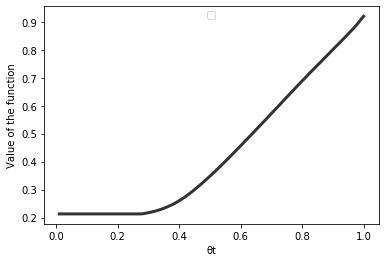

<function s_respond at 0x000001A874256F78>

No handles with labels found to put in legend.


 ℓkt =  0.3 ℓmt =  0.5


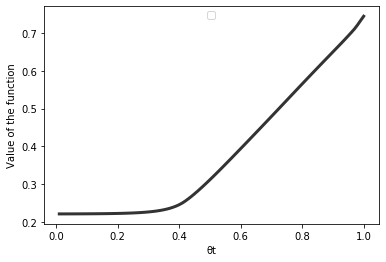

In [189]:
graf_func(θs_vals, 1, 's', s_propose, ℓkt = 0.3, ℓmt = 0.5)
graf_func(θs_vals, 1, 's', s_respond, ℓkt = 0.3, ℓmt = 0.5)

#repare que a função s_propose tem uma descontinuidade quando θkt = ℓmt = 0.5. Não entendi bem o motivo disso. 


#a função 



No handles with labels found to put in legend.


<function s_propose at 0x000001A844664DC8> ℓkt =  0.3 ℓmt =  0.9


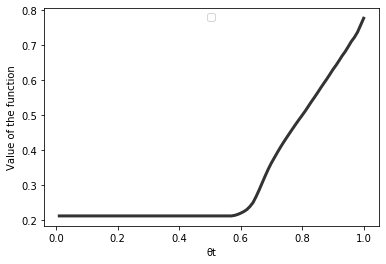

No handles with labels found to put in legend.


<function s_respond at 0x000001A874256F78> ℓkt =  0.3 ℓmt =  0.9


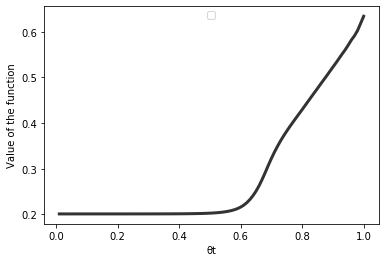

In [191]:
graf_func(θs_vals, 1, 's', s_propose, ℓkt = 0.3, ℓmt = 0.9)
graf_func(θs_vals, 1, 's', s_respond, ℓkt = 0.3, ℓmt = 0.9)

#quando ℓmt = 0.9, a função fica mais estranha.

No handles with labels found to put in legend.


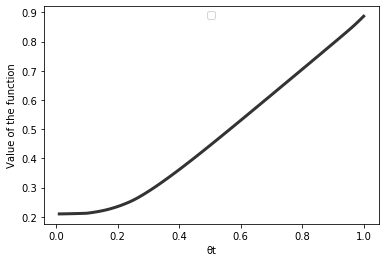

No handles with labels found to put in legend.


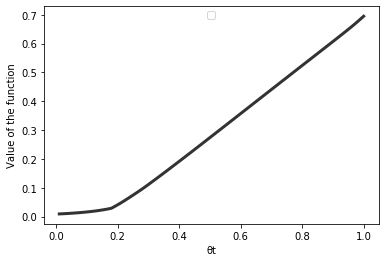

In [192]:
#gráfico da função valor

def graf_func_value(k_array, ℓkt, ℓmt, t):
    #t starts at t=1
    
    fig, ax = plt.subplots()

    #size of X axis
    X = θs_vals


    #storing the function vals in t
    graf_vals = k_array[:, find(ℓkt), find(ℓmt), (t-1)]


    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)
    
#     name = str(k_array)
#     title_val = print(name, 'ℓkt = ', ℓkt, 'ℓmt = ', ℓmt, 'period = ', t)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")


    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()
    
graf_func_value(s_W, ℓkt = 0.01, ℓmt = 0.02, t = 1)

graf_func_value(j_W, ℓkt = 0.01, ℓmt = 0.02, t = 1)
#o valor de continuação tem uma queda quando θkt == ℓkt. Deve ser por causa dos cálculos de valor esperado.

In [193]:
#gráfico das propostas

def graf_proposal(function, function_name, t, xlabel, ylabel):
    

    grid_graf = len(θs_vals)

    graf = np.empty((grid_graf, grid_graf))

    for i, θs in enumerate(θs_vals):
        for j, lj in enumerate(lj_vals):
            graf[i,j] = function(θs, θs, lj, t)[1]


    fig, ax = plt.subplots()

    cs1 = ax.contourf(θs_vals, lj_vals, graf.T, alpha=0.75)
    # ctr1 = ax.contour(θs_vals, lj_vals, graf1.T)
    # plt.clabel(ctr1, inline=1, fontsize=13)
    plt.colorbar(cs1, ax = ax)

    ax.set_title('Function ' + function_name +   ' in period ' + str(t) )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    ax.ticklabel_format(useOffset=False)


    plt.show()

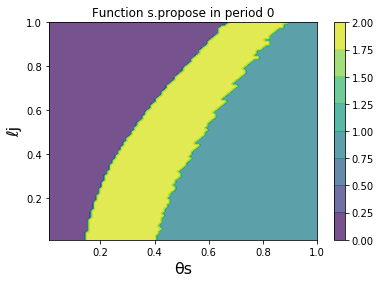

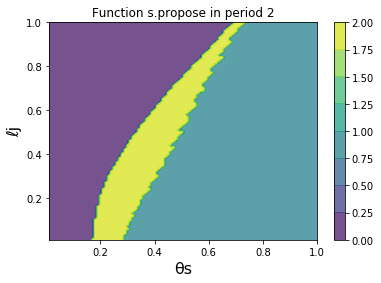

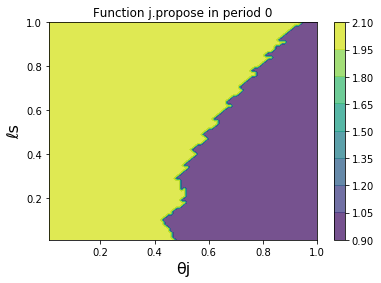

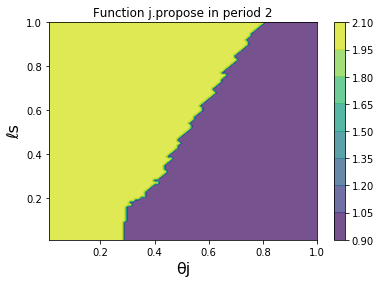

In [194]:
graf_proposal(s_propose,'s.propose', 0, 'θs', 'ℓj')

graf_proposal(s_propose,'s.propose', 2, 'θs', 'ℓj')

graf_proposal(j_propose, 'j.propose', 0, 'θj', 'ℓs')
graf_proposal(j_propose, 'j.propose', 2, 'θj', 'ℓs')




In [66]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def graf_proposal(function, function_name, t, xlabel, ylabel):
    

    grid_graf = len(θs_vals)

    graf = np.empty((grid_graf, grid_graf))

    for i, θs in enumerate(θs_vals):
        for j, lj in enumerate(lj_vals):
            graf[i,j] = function(θs, θs, lj, t)[1]


    fig, ax = plt.subplots()
    
    X, Y = np.meshgrid(θs_vals, θs_vals)
    
    
    colormap = ListedColormap(['black', 'blue', 'red'])
    

    plt.scatter(X, Y, c=graf.T, s=10, cmap=colormap, edgecolors='none') 
    # ctr1 = ax.contour(θs_vals, lj_vals, graf1.T)
    # plt.clabel(ctr1, inline=1, fontsize=13)

    ax.set_title('Function ' + function_name +   ' in period ' + str(t) )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    ax.ticklabel_format(useOffset=False)


    plt.show()









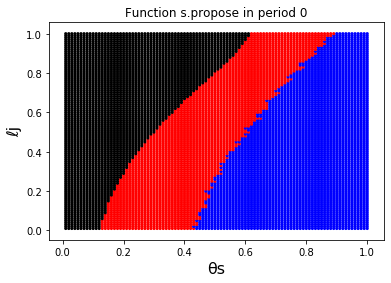

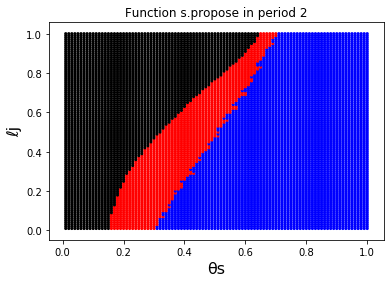

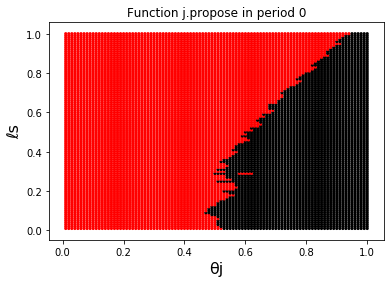

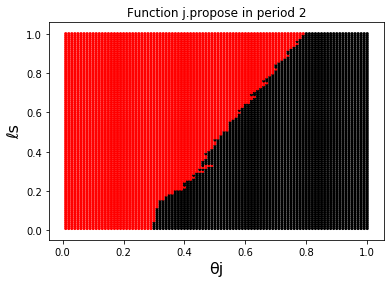

In [67]:
graf_proposal(s_propose,'s.propose', 0, 'θs', 'ℓj')

graf_proposal(s_propose,'s.propose', 2, 'θs', 'ℓj')

graf_proposal(j_propose, 'j.propose', 0, 'θj', 'ℓs')
graf_proposal(j_propose, 'j.propose', 2, 'θj', 'ℓs')




# Passo 5: resolvendo a negociação entre os credores

Aqui vamos resolver o jogo de fato.

Etapas:

1. Os dois credores recebem suas habilidades, que são informação privada
2. Um credor é sorteado para propor o que fazer com a firma
3. Há uma atualização nos lower bounds das habilidades para o próximo período
4. Usando os lower bounds do próximo período, o credor propositor faz uma oferta baseado no valor de continuação esperado para o próximo período (o dele próprio e o do adversário)
5. Há uma atualização das habilidades verdadeiras para o próximo período, que são informação privada
6. O credor respondente olha a sua habilidade para o próximo período, os lower bounds do próximo período, calcula seu valor de continuação do próximo período e dá uma resposta.
4. O jogo acaba quando os dois concordam quanto ao que fazer com a firma


O resultado final é um vetor contendo 3 coisas:
1. A taxa de recuperação de crédito (o quanto cada credor recebeu em relação ao que ele tinha de crédito)
2. Em qual turno a negociação acabou
3. O que decidiram fazer com a firma (reorganizar ou liquidar)



#### Barganha completa: com s ou j propondo

In [ ]:
#loop while resultado[3] diferente de t, continua



#parâmetros iniciais
t = 0

θst = θ_s0
θjt = θ_j0

#assumindo que lower bounds nos períodos iniciais são as próprias habilidades iniciais
lst = θ_s0
ljt = θ_j0


#vetor com payoff de s, payoff de j, destino da firma e período
#destino da firma é 0 (liquidou) ou 1 (reorganizou)
resultado = np.zeros(4)


#loop roda enquanto não encerrarem o jogo
#o payoff dos jogadores só é gravado no resultado o jogo acaba. 
#Então o loop vai rodar até que o payoff seja diferente do valor inicial, que é zero
while(resultado[0] == 0):
    




    #sorteio do jogador proponente

    u = uniform(0, 1)

    if(u < λj):
        propositor = 'j'

    else:
        propositor = 's'



    if(propositor == 's'):
        



        # se s é chamado a propor ####

        #proposta
        # 0 é liquidar
        # 1 é reorganizar
        # 2 é esperar

        proposta = St(θst, lst, ljt, t)[1]

        payoff_s = St(θst, lst, ljt, t)[0]

        #update dos lower bounds
        ls_next = St(θst, lst, ljt, t)[2]

        #lj_next não pode alterar caso a proposta seja de espera, pois não há cutoff
        lj_next = St(θst, lst, ljt, t)[3]


        #jeito resumido
        # [payoff_s, proposta, ls_next, lj_next] = St(θst, lst, ljt, 0)[1:]

        #update das habilidades à tarde
        θs_next = round(draw_beta(θst), 2)
        θj_next = round(draw_beta(θjt), 2)



        if(proposta == 0):

            #o que j faz se s propor liquidar?
            #j olha sua habilidade e os lower bounds do próximo período e calcula o valor de continuação
            #aqui ele olha o valor de continuação dele de fato, sem ser valor esperado. Então a função é diferente de j_liq

            jt_liq_valor = [Lj(t), V[t] * θj_next - Ls(t) ]

            resposta = np.argmax(jt_liq_valor)

            payoff_j = jt_liq_valor[resposta]


            if(resposta == 0):
                #j concorda em liquidar
                #payoffs são os de liquidação

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 0 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j prefere reorganizar
                #payoff de s é liq, payoff de j é de reorganização

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #1 é caso reorganize
                resultado[3] = t 

            #em qualquer cenário, quando o oponente propôe liquidar o jogo acaba. Por isso sempre temos resultado[3] = t

        if(proposta == 1):
            #o que j faz se s propor reorganizar?

            #a proposta de pagamento de s é o valor esperado da função valor de j, com base nas informações que s tem hoje
            Pst = Ewj(expec_beta(lj_next), ls_next, lj_next, t+1)

            jt_reorg_valor = [Pst, Ewj(θj_next, ls_next, lj_next, t+1)]

            resposta = np.argmax(jt_reorg_valor)

            payoff_j = jt_reorg_valor[resposta]



            if(resposta == 0):
                #j concorda com a proposta de pagamento

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j recusa a proposta de pagamento
                #jogo vai para o próximo período
                #vai para o próximo período

                t += 1

                #update das informações
                θst = θs_next
                θjt = θj_next
                lst = ls_next
                ljt = lj_next


        if(proposta == 2):
            #o que acontece se s propor esperar?
            #vai para o próximo período

            t += 1

            #update das informações
            θst = θs_next
            θjt = θj_next
            lst = ls_next
            #ljt não sofre alteração na proposta de esperar


    #============================================================================
    else: #caso quem proponha seja j


        # se j é chamado a propor ####

        #proposta
        # 0 é liquidar
        # 1 é reorganizar
        # 2 é esperar

        proposta = Jt(θst, lst, ljt, t)[1]

        payoff_j = Jt(θst, lst, ljt, t)[0]

        #update dos lower bounds
        ls_next = Jt(θst, lst, ljt, t)[2]

        #ls_next não pode alterar caso a proposta seja de espera, pois não há cutoff
        lj_next = Jt(θst, lst, ljt, t)[3]


        #jeito resumido


        #update das habilidades à tarde
        θs_next = round(draw_beta(θst), 2)
        θj_next = round(draw_beta(θjt), 2)



        if(proposta == 0):

            #o que j faz se s propor liquidar?
            #j olha sua habilidade e os lower bounds do próximo período e calcula o valor de continuação
            #aqui ele olha o valor de continuação dele de fato, sem ser valor esperado. Então a função é diferente de j_liq

            st_liq_valor = [Ls(t), V[t] * θs_next - Lj(t) ]

            resposta = np.argmax(st_liq_valor)

            payoff_s = st_liq_valor[resposta]


            if(resposta == 0):
                #j concorda em liquidar
                #payoffs são os de liquidação

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 0 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #j prefere reorganizar
                #payoff de s é liq, payoff de j é de reorganização

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #1 é caso reorganize
                resultado[3] = t 

            #em qualquer cenário, quando o oponente propôe liquidar o jogo acaba. Por isso sempre temos resultado[3] = t

        if(proposta == 1):
            #o que s faz se j propor reorganizar?

            Pjt = Ews(expec_beta(ls_next), ls_next, lj_next, t+1)

            st_reorg_valor = [Pjt, Ews(θs_next, ls_next, lj_next, t+1)]

            resposta = np.argmax(st_reorg_valor)

            payoff_s = st_reorg_valor[resposta]



            if(resposta == 0):
                #s concorda com a proposta de pagamento

                resultado[0] = payoff_s
                resultado[1] = payoff_j
                resultado[2] = 1 #0 é caso liquide
                resultado[3] = t


            if(resposta == 1):
                #s recusa a proposta de pagamento
                #jogo vai para o próximo período

                t += 1

                #update das informações
                θst = θs_next
                θjt = θj_next
                lst = ls_next
                ljt = lj_next


        if(proposta == 2):
            #o que acontece se s propor esperar?
            #vai para o próximo período

            t += 1

            #update das informações
            θst = θs_next
            θjt = θj_next
            ljt = lj_next
            #lst não sofre alteração na proposta de esperar


In [ ]:
θst
θjt

resultado

proposta

t
propositor

#agora falta fazer a média dos valores de negociação para colocar como um momento



# Próximos passos



* HIGIENIZAR O CÓDIGO, DEIXAR ORGANIZADO!


* ~debugar o que acontece quando t = 14~
    * bug na função pmf, e acho que vem da função bins() também


* ~criar função de esperança baseada na função beta~
    * expec_beta(info_hoje) retorna o valor esperado de teta amanhã




* ~discretizar a beta para obter a esperança das funções valor no período seguinte~



* ~fazer Js_val~

* ~guardar resultados de Js_val e Ws_val do último período numa  matriz 4D~

* ~pensar numa função Js_next para achar o valor de Js no próximo período baseado nos parâmetros deste período~
    * regra para atualização de lst
    * regra para atualização de ljt
    * expectativa da habilidade no período seguinte

* ~pensar na forma recursiva do jogo~
    * acho que as funções probabilidade também têm que considerar o update do lower bound, pois elas fazem parte do cenário onde o jogador não propõe


* checar todas as funções de cálculo do jogo (Passo 3)


* considerar a estrutura de negociação do jogo

* aumentar a precisão das estimativas do jogo
    * algoritmo para cálculo do cutoff pode ter mais casas decimais
    
    
 * fazer uma estrutura mais enxuta, com uma função que tome como argumento se é s ou j. Ao invés de criar St, Jt, st, jt...
    


* passos finais
    * replicar os gráficos do artigo de referência


### Conferir novamente

1. ~Se preciso usar ls_next e lj_next nas funções Prob_s e Prob_j~ 
   * conferi e precisa sim, já arrumei

2. Se o valor esperado da função para calcular os thresholds cst e cjt estão corretos

3. A função pmf não está somando um, tem que verificar onde está o erro

